# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
import pickle
import torch
import io
from geo_northarrow import add_north_arrow
import ast



In [2]:
# change directory if necessary
os.chdir("../..")
os.getcwd()

'/Users/jiayilow/Desktop/CASA/Dissertation/mapping_reform'

# Loading post-NER+RE data

In [3]:
events_post_re = pd.read_csv("output_data/ner_re_done_v2.csv")
events_post_re

,corpus_id,sentence,event,venue,location,re_venue,re_location
0,178361,"On Monday evening last, the 3rd instant, the W...",assembly,NaN,Hull,NaN,Hull
1,178361,The chairman then read a letter received on Su...,meeting,Old Palace Yard,Westminster,Old Palace Yard,Westminster
2,454650,The London Chartists are auxiously invited to ...,public meeting,Workhouse Yard,Marylebone,Workhouse Yard,Marylebone
3,454650,This will be the most important meeting ever h...,meeting,NaN,London,NaN,London
4,454650,F. O'Connor will address a general meeting of ...,meeting,Social Institution,"John-street, Tottenham-Court-road",Social Institution,NaN
...,...,...,...,...,...,...,...
44024,239515,"The Eastern Philanthropic Emergency Society, h...",meeting,"Mr. Drakes, Standard of Liberty","Brick-lane, Spitalfields",NaN,Spitalfields
44025,239515,The National Victim Committee will meet (to ag...,meeting,South London Char,Leeds,South London Char,NaN
44026,609473,"The meeting was announced for seven o'clock, b...",meeting,Free Trade Hall,NaN,Free Trade Hall,NaN
44027,556610,We have but just time to point attention to th...,meeting,NaN,Burnley,NaN,Burnley


## Loading article metadata

In [4]:
class CPUUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

# initialising empty dict to store
publication_data = {}

# reading in publication vector pickle files 
embedding_dir = "output_data/article_embeddings/embeddings_mpnet"

for filename in os.listdir(embedding_dir):
    filepath = os.path.join(embedding_dir, filename)
    print(f"Loading data for {filepath}...")
    with open(filepath, "rb") as f:
        data = CPUUnpickler(f).load()
        publication_data[filename] = data

# Prepare lists to hold everything
all_articles = []
all_embeddings = []
all_dates = []
all_sources = []

# loading everything into one structure
for name, pubdata in {
    'ewj': publication_data["the_english_womans_journal.pkl"],
    'star': publication_data["the_northern_star.pkl"],
    'leader': publication_data["the_leader.pkl"],
    'circ': publication_data['the_publishers_circular.pkl'],
    'tomahawk': publication_data['the_tomahawk.pkl'],
    'repo': publication_data['the_monthly_repository.pkl']
}.items():
    all_articles.extend(pubdata['articles'])
    all_embeddings.extend(pubdata['embeddings'])
    all_dates.extend(pubdata['dates'])
    all_sources.extend([name] * len(pubdata['articles']))

Loading data for output_data/article_embeddings/embeddings_mpnet/the_northern_star.pkl...
Loading data for output_data/article_embeddings/embeddings_mpnet/the_english_womans_journal.pkl...
Loading data for output_data/article_embeddings/embeddings_mpnet/the_leader.pkl...
Loading data for output_data/article_embeddings/embeddings_mpnet/the_publishers_circular.pkl...
Loading data for output_data/article_embeddings/embeddings_mpnet/the_tomahawk.pkl...
Loading data for output_data/article_embeddings/embeddings_mpnet/the_monthly_repository.pkl...


# Loading gazetteer

In [5]:
gbpn = pd.read_csv("data/geoparsing_data/GBPN.csv", 
                   dtype={9: "string",
                          13: "string",
                          16: "string"})

# selecting columns i gaf about
gbpn = gbpn[['GBPNID', 'PlaceName', 'NameType', 'Type', 'HistCounty', 'Region', 'Lat', 'Lng']]
gbpn.head()                          

,GBPNID,PlaceName,NameType,Type,HistCounty,Region,Lat,Lng
0,1,A' Chill,P,Hamlet,Argyllshire,Scotland,57.057719,-6.500908
1,2,Ab Kettleby,P,Village,Leicestershire,England,52.800049,-0.927993
2,3,Ab Lench,P,Hamlet,Worcestershire,England,52.163533,-1.980962
3,4,Abbeycwmhir,P,Hamlet,Radnorshire,Wales,52.331015,-3.389919
4,4,Abaty Cwm-hir,C,Hamlet,Radnorshire,Wales,52.331015,-3.389919


# Loading GB county shapefiles
Data is from https://county-borders.co.uk/

In [6]:
counties_path = "data/geoparsing_data/UKDefinitionB_OSGB_Full_Resolution/UKDefinitionB.shp"
counties = gpd.read_file(counties_path)

# filtering out northern ireland counties
ni_counties = ['Antrim', 'Armagh', 'Down', 'Fermanagh', 'Londonderry', 'Tyrone']
gb_counties = counties[~counties['NAME'].isin(ni_counties)].copy()
gb_counties

,NAME,COUNTY,ABBR,HCS_NUMBER,HCS_CODE,geometry
0,Aberdeenshire,Aberdeen,Aber,1,ABN,"MULTIPOLYGON (((342589.132 839263.386, 342580...."
1,Anglesey,Anglesey,Angle,2,AGL,"MULTIPOLYGON (((224718.558 383238.255, 224719...."
2,Angus,Angus,Ang,3,ANG,"MULTIPOLYGON (((370655.614 748115.446, 370653...."
4,Argyllshire,Argyll,Argyll,5,ARG,"MULTIPOLYGON (((211212.557 775556.094, 211198...."
6,Ayrshire,Ayr,Ayr,7,AYS,"MULTIPOLYGON (((219856.152 603170.384, 219860...."
...,...,...,...,...,...,...
87,Westmorland,Westmorland,Westm,88,WML,"MULTIPOLYGON (((353662.462 476507.789, 353671...."
88,Wigtownshire,Wigtown,Wigtown,89,WGT,"MULTIPOLYGON (((244541.375 534362.165, 244540...."
89,Wiltshire,Wilts,Wilts,90,WTS,"MULTIPOLYGON (((472728.929 164809.005, 472731...."
90,Worcestershire,Worcester,Worcs,91,WRC,"MULTIPOLYGON (((399890.608 287796.259, 399895...."


<Axes: >

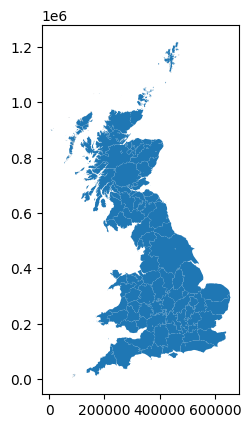

In [7]:
gb_counties.plot()

# Loading 1841 population data
Data is from http://www.histpop.org/ohpr/servlet/Browse?path=Browse/Census%20(by%20date)/1841&active=no&treestate=expand

In [8]:
# reading in externally- and manually-populated 1841 population data
# NOTE: ORKNEY and SHETLAND have a combined population here!!!!
pop = pd.read_csv("data/hc_pop.csv")
pop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   NAME      86 non-null     object
 1   pop_1841  86 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


# Cleaning and preprocessing data

In [9]:
# cleaning articles df 
cols_to_clean_articles = ['venue', 'location', 're_venue', 're_location']

# iterating over cols_to_clean_articles and lowercasing+stripping them
for col in cols_to_clean_articles:
    events_post_re[col] = events_post_re[col].astype(str).str.lower().str.strip()

# renaming ner columns to avoid confusion later
events_post_re.rename(columns={'event': 'ner_event',
                     'venue': 'ner_venue',
                     'location': 'ner_location'})

,corpus_id,sentence,ner_event,ner_venue,ner_location,re_venue,re_location
0,178361,"On Monday evening last, the 3rd instant, the W...",assembly,nan,hull,nan,hull
1,178361,The chairman then read a letter received on Su...,meeting,old palace yard,westminster,old palace yard,westminster
2,454650,The London Chartists are auxiously invited to ...,public meeting,workhouse yard,marylebone,workhouse yard,marylebone
3,454650,This will be the most important meeting ever h...,meeting,nan,london,nan,london
4,454650,F. O'Connor will address a general meeting of ...,meeting,social institution,"john-street, tottenham-court-road",social institution,nan
...,...,...,...,...,...,...,...
44024,239515,"The Eastern Philanthropic Emergency Society, h...",meeting,"mr. drakes, standard of liberty","brick-lane, spitalfields",nan,spitalfields
44025,239515,The National Victim Committee will meet (to ag...,meeting,south london char,leeds,south london char,nan
44026,609473,"The meeting was announced for seven o'clock, b...",meeting,free trade hall,nan,free trade hall,nan
44027,556610,We have but just time to point attention to th...,meeting,nan,burnley,nan,burnley


In [10]:
# cleaning gbpn data
cols_to_clean_gbpn = ['PlaceName', 'NameType', 'Type', 'HistCounty', 'Region']
for col in cols_to_clean_gbpn:
    gbpn[col] = gbpn[col].astype(str).str.lower().str.strip()

gbpn.head()

,GBPNID,PlaceName,NameType,Type,HistCounty,Region,Lat,Lng
0,1,a' chill,p,hamlet,argyllshire,scotland,57.057719,-6.500908
1,2,ab kettleby,p,village,leicestershire,england,52.800049,-0.927993
2,3,ab lench,p,hamlet,worcestershire,england,52.163533,-1.980962
3,4,abbeycwmhir,p,hamlet,radnorshire,wales,52.331015,-3.389919
4,4,abaty cwm-hir,c,hamlet,radnorshire,wales,52.331015,-3.389919


In [11]:
# cleaning county border data
cols_to_clean_counties = ['NAME']
gb_counties = gb_counties[['NAME', 'HCS_NUMBER', 'geometry']]
for col in cols_to_clean_counties:
    gb_counties[col] = gb_counties[col].astype(str).str.lower().str.strip()

gb_counties

/Users/jiayilow/Desktop/CASA/Dissertation/mapping_reform/diss-venv311/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,NAME,HCS_NUMBER,geometry
0,aberdeenshire,1,"MULTIPOLYGON (((342589.132 839263.386, 342580...."
1,anglesey,2,"MULTIPOLYGON (((224718.558 383238.255, 224719...."
2,angus,3,"MULTIPOLYGON (((370655.614 748115.446, 370653...."
4,argyllshire,5,"MULTIPOLYGON (((211212.557 775556.094, 211198...."
6,ayrshire,7,"MULTIPOLYGON (((219856.152 603170.384, 219860...."
...,...,...,...
87,westmorland,88,"MULTIPOLYGON (((353662.462 476507.789, 353671...."
88,wigtownshire,89,"MULTIPOLYGON (((244541.375 534362.165, 244540...."
89,wiltshire,90,"MULTIPOLYGON (((472728.929 164809.005, 472731...."
90,worcestershire,91,"MULTIPOLYGON (((399890.608 287796.259, 399895...."


In [12]:
# adding population data to county data
gb_counties = gb_counties.merge(pop, on='NAME', how='left')
gb_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        86 non-null     object  
 1   HCS_NUMBER  86 non-null     int32   
 2   geometry    86 non-null     geometry
 3   pop_1841    86 non-null     int64   
dtypes: geometry(1), int32(1), int64(1), object(1)
memory usage: 2.5+ KB


## Matching matched_location in article df to gazetteer
1. create lookup dictionaries from GBPN's PlaceName and HistCounty columns
2. first looking in PlaceName to look for matches
3. if not, looking in HistCounty
4. appending (matched PlaceName + corresponding HistCounty + corresponding region) OR (matched HistCounty + corresponding region) to article df

In [13]:
if os.path.exists(os.path.join("output_data", "gazetteer_matched.csv")):
    print(f"Found file containing gazetteer-matched events.")
    df_gazmatched = pd.read_csv(os.path.join("output_data", "gazetteer_matched.csv"))
    print(f"Loaded {len(df_gazmatched)} rows.")
else:
    print(f"File containing gazetteer-matched events not found. Commencing matching process...")


    # creating lookup dictionaries, accounting for cases where multiple places have the same name
    place_lookup = (gbpn.groupby('PlaceName', group_keys=False)
                    .apply(lambda g: g.to_dict(orient='records'))
                    .to_dict()
                   )
    
    county_lookup = (gbpn.groupby('HistCounty', group_keys=False)
                    .apply(lambda g: g.to_dict(orient='records'))
                    .to_dict()
                   )

    # ==============================================================================
    # FUNCTION TO MATCH RE_LOCATION TO GAZETTEER PLACE NAME OR COUNTY NAME
    # ==============================================================================
    
    def extract_gazetteer_matches(location, place_lookup=place_lookup, county_lookup=county_lookup):
        """
        Returns a Series with matched gazetteer data for a given location.
        Preserves 1:1 row alignment for all matched records.
        """
        columns = ['gaz_place', 'gaz_county', 'gaz_region', 'lat', 'lng']
        empty_result = pd.Series({col: np.nan for col in columns})
    
        if pd.isna(location):
            return empty_result
    
        # First, check for matches in PlaceName
        if location in place_lookup:
            matches = place_lookup[location]
            return pd.Series({
                'gaz_place':   [m['PlaceName'] for m in matches],
                'gaz_county':  [m['HistCounty'] for m in matches],
                'gaz_region':  [m['Region'] for m in matches],
                'lat':         [m['Lat'] for m in matches],
                'lng':         [m['Lng'] for m in matches]
            })
    
        # If no place match, check in HistCounty
        if location in county_lookup:
            matches = county_lookup[location]
            return pd.Series({
                'gaz_place':   [m['PlaceName'] for m in matches],  # may be NaN or partial
                'gaz_county':  [m['HistCounty'] for m in matches],
                'gaz_region':  [m['Region'] for m in matches],
                'lat':         [m['Lat'] for m in matches],
                'lng':         [m['Lng'] for m in matches]
            })
    
        return empty_result  
        
    # ==============================================================================
    # MASTER FUNCTION
    # ==============================================================================
    
    def match_gazetteer(article_df, gaz=gbpn):
        """
        Main function: Takes an article dataframe and gazetteer dataframe.
        Returns the article_df with appended gazetteer matches.
        """
        # Apply matching function row-wise
        matches = article_df['re_location'].apply(lambda loc: extract_gazetteer_matches(loc, place_lookup, county_lookup))
    
        # Concatenate original df with match results
        return pd.concat([article_df, matches], axis=1)

    
    df_gazmatched = match_gazetteer(events_post_re)
    df_gazmatched.to_csv("output_data/gazetteer_matched.csv", index=False, encoding="utf-8-sig")

Found file containing gazetteer-matched events.
Loaded 44029 rows.


## Converting gazetteer-matched output to GDF

In [14]:
# exploding test_gazmatched for now.. need to come back and think about how to handle multi-match situations

# this is to address the string issues when reading in df_gazmatched from file
for col in ['gaz_place', 'gaz_county', 'gaz_region', 'lat', 'lng']:
    df_gazmatched[col] = df_gazmatched[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

df_gazmatched_exp = df_gazmatched.explode(['gaz_place','gaz_county','gaz_region','lat','lng'], ignore_index=True)

events_gdf = gpd.GeoDataFrame(df_gazmatched_exp,
                              geometry=gpd.points_from_xy(df_gazmatched_exp.lng.astype(float), 
                                                          df_gazmatched_exp.lat.astype(float)),
                              crs="EPSG:4326")

# convert events_gdf to county shapefile's CRS
events_gdf = events_gdf.to_crs(counties.crs)
events_gdf

,corpus_id,sentence,event,venue,location,re_venue,re_location,gaz_place,gaz_county,gaz_region,lat,lng,geometry
0,178361,"On Monday evening last, the 3rd instant, the W...",assembly,NaN,hull,NaN,hull,hull,yorkshire,england,53.743672,-0.339018,POINT (509640.562 428757.209)
1,178361,The chairman then read a letter received on Su...,meeting,old palace yard,westminster,old palace yard,westminster,westminster,northamptonshire,england,52.027386,-1.145371,POINT (458732.999 236897.05)
2,178361,The chairman then read a letter received on Su...,meeting,old palace yard,westminster,old palace yard,westminster,westminster,middlesex,england,51.498502,-0.135148,POINT (529544.041 179377.588)
3,454650,The London Chartists are auxiously invited to ...,public meeting,workhouse yard,marylebone,workhouse yard,marylebone,marylebone,lancashire,england,53.560696,-2.627649,POINT (358522.43 407303.031)
4,454650,The London Chartists are auxiously invited to ...,public meeting,workhouse yard,marylebone,workhouse yard,marylebone,marylebone,middlesex,england,51.522946,-0.152573,POINT (528265.974 182065.185)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76474,239515,"The Eastern Philanthropic Emergency Society, h...",meeting,"mr. drakes, standard of liberty","brick-lane, spitalfields",NaN,spitalfields,spitalfields,middlesex,england,51.519156,-0.074619,POINT (533684.847 181783.14)
76475,239515,The National Victim Committee will meet (to ag...,meeting,south london char,leeds,south london char,NaN,NaN,NaN,NaN,NaN,NaN,POINT (Infinity Infinity)
76476,609473,"The meeting was announced for seven o'clock, b...",meeting,free trade hall,NaN,free trade hall,NaN,NaN,NaN,NaN,NaN,NaN,POINT (Infinity Infinity)
76477,556610,We have but just time to point attention to th...,meeting,NaN,burnley,NaN,burnley,burnley,lancashire,england,53.790252,-2.24372,POINT (384041.163 432687.171)


In [15]:
# dropping rows with unparseable locations

original_count = len(events_gdf)
    
# Filter out rows where geometry contains infinity
valid_mask = events_gdf['geometry'].apply(lambda geom: np.isfinite(geom.x) and np.isfinite(geom.y) if geom is not None else False)
    
filtered_gdf = events_gdf[valid_mask].copy()
    
filtered_count = len(filtered_gdf)
dropped_count = original_count - filtered_count
    
print(f"Original dataset: {original_count:,} rows")
print(f"Filtered dataset: {filtered_count:,} rows") 
print(f"Rows dropped: {dropped_count:,} ({dropped_count/original_count*100:.2f}%)")

Original dataset: 76,479 rows
Filtered dataset: 53,994 rows
Rows dropped: 22,485 (29.40%)


# Joining events gdf to county shapefile

In [16]:
joined = gpd.sjoin(filtered_gdf,
                   gb_counties[['NAME','geometry', 'HCS_NUMBER']],
                   how="left",
                   predicate="within")
joined=joined.drop(columns='index_right')
joined
# note: this spatial join seems to, unless i'm mistaken, very nicely solve the issue of historic counties that no longer function as administrative counties
# e.g. Middlesex, identified and gazetteer-matched as a historic county, falls within London's boundaries and is identified as such!

print(f"Number of rows if all potential name matches are kept: {len(joined)}.")

Number of rows if all potential name matches are kept: 53994.


## CHECKPOINT
At this point, it's useful to check in on what's been merged so i don't get in a mess about what is what..
Columns in joined:
1. corpus_id
2. sentence
3. event - identified at NER stage by spaCy
4. venue - identified at NER stage by GLiNER
5. location - identified at NER stage by GLiNER
6. matched_venue - identified at RE stage by spaCy
7. matched_location - identified at RE stage by spaCy
8. gaz_place - identified at geocoding stage by string matching with GBPN
9. gaz_county - identified at geocoding stage by string matching with GBPN, OR by retrieving corresponding county after identifying gaz_place
10. gaz_region - retrieved from corresponding region after identifying gaz_place/gaz_county
11. lat and lng - coordinates retrieved from gazetteer-extracted place/county information. afaik these are the coords for whatever granularity is able to be extracted (place if possible, otherwise county)
12. geometry - county boundary polygons
13. area - county areas retrieved from ONS csv file -> not applicable if using HCT data

# Checking extent of multi-match sentences (place name traced to >1 county)

In [17]:

# 1. Print full length of original dataframe
print("Original length (keeping all potential matches):", len(joined))

# 2. Calculate length of dataframe with unique sentences (keeping only first occurrence)
unique_sentences_df = joined.drop_duplicates(subset=['sentence'], keep='first')
print("Length with unique sentences:", len(unique_sentences_df))

# 3. Identify sentences that are duplicated
duplicated_sentences = joined['sentence'][joined['sentence'].duplicated(keep=False)]
print(f"No. of multi-match sentences: {len(duplicated_sentences)}")

# Drop all rows where 'sentence' is duplicated
joined_dropdup = joined[~joined['sentence'].isin(duplicated_sentences)].reset_index()

# 4. Print length of resulting dataframe (after removing all duplicates)
print("Length after removing repeated sentences:", len(joined_dropdup))


Original length (keeping all potential matches): 53994
Length with unique sentences: 13822
No. of multi-match sentences: 47921
Length after removing repeated sentences: 6073


# Setting official colours for event types

In [18]:
colour_map = {
    'meeting': '#005BB3',          # deep blue
    'public meeting': '#82CAFF',   # light blue
    'lecture': '#7E5A9B',          # muted purple
    'assembly': '#029456',         # dark green
    'gathering': '#7ED29F',        # light green
    'demonstration': '#D8226C',    # pinkish/magenta
    'strike': '#F86A38',           # warm orange/red
    'protest': '#D8B822',          # mustard yellow
    'riot': '#B32222',             # brick red
}

# Temporal exploration

In [19]:
# adding article date using metadata loaded above  
joined['date'] = joined['corpus_id'].apply(lambda idx: all_dates[idx])
joined['source'] = joined['corpus_id'].apply(lambda idx: all_sources[idx])
joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 53994 entries, 0 to 76478
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   corpus_id    53994 non-null  int64         
 1   sentence     53994 non-null  object        
 2   event        53994 non-null  object        
 3   venue        19585 non-null  object        
 4   location     53994 non-null  object        
 5   re_venue     11346 non-null  object        
 6   re_location  53994 non-null  object        
 7   gaz_place    53994 non-null  object        
 8   gaz_county   53994 non-null  object        
 9   gaz_region   53994 non-null  object        
 10  lat          53994 non-null  object        
 11  lng          53994 non-null  object        
 12  geometry     53994 non-null  geometry      
 13  NAME         53734 non-null  object        
 14  HCS_NUMBER   53734 non-null  float64       
 15  date         53994 non-null  datetime64[ns]
 16  s

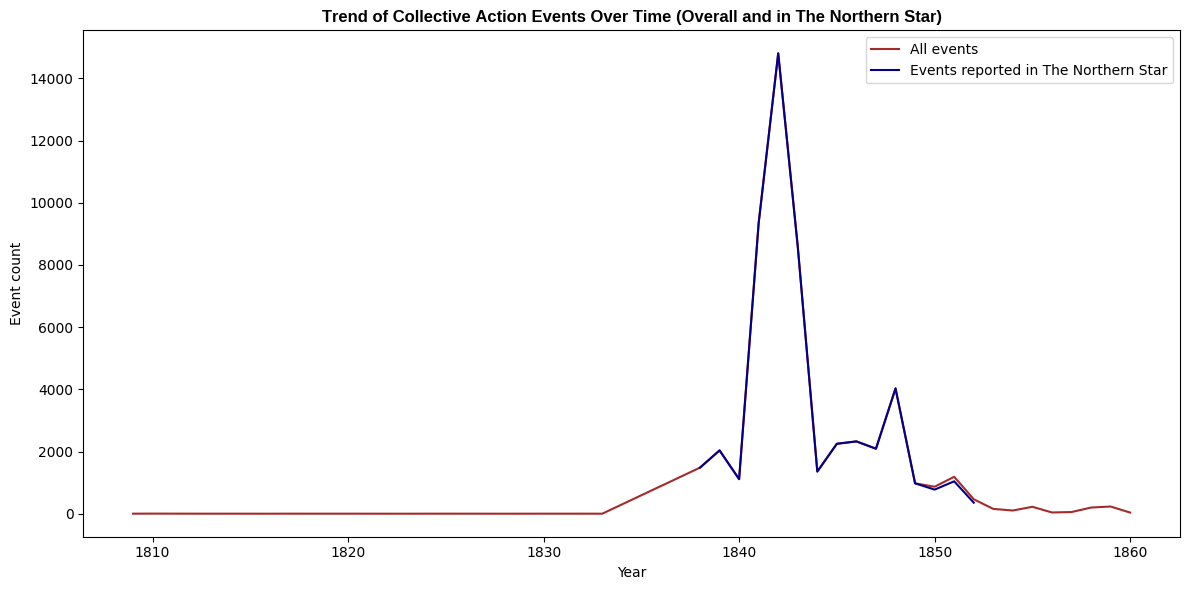

In [20]:
# 1. LINE CHART of articles over time

joined['year'] = joined['date'].dt.year
joined_by_year = joined.groupby('year').size().reset_index(name='count')

# the northern star
star_by_year = joined[joined['source'] == 'star'].groupby('year').size().reset_index(name='star_count')

plt.figure(figsize=(12,6))

# plotting overall entries
sns.lineplot(data=joined_by_year,
             x='year', 
             y='count',
             color='brown', label='All events')

# plotting northern star entries
sns.lineplot(data=star_by_year, x='year', y='star_count', color='darkblue', label='Events reported in The Northern Star')

plt.title("Trend of Collective Action Events Over Time (Overall and in The Northern Star)", 
                     fontweight='bold',
                    fontname='Liberation Sans')

plt.xlabel("Year")
plt.ylabel("Event count")

plt.tight_layout()
plt.show()

In [21]:
# understanding time series of events
events_over_time = joined.groupby(['date', 'year', 'event']).size().reset_index(name='count')

# descriptive stats for event counts over time (all years)
events_over_time_grouped = events_over_time.groupby(['year'], as_index=False)['count'].sum()
print(events_over_time_grouped[['count']].describe())

print(f"{events_over_time_grouped.loc[events_over_time_grouped['count'].idxmax(), 'year']} had the highest number of identified events ({events_over_time_grouped['count'].max()}).")
print(f"{events_over_time_grouped.loc[events_over_time_grouped['count'].idxmin(), 'year']} had the lowest number of identified events ({events_over_time_grouped['count'].min()}).")

print(f"A smaller spike is observed in 1848, with {events_over_time_grouped.loc[events_over_time_grouped['year'] == 1848, 'count'].iloc[0]} identified events.")

              count
count     33.000000
mean    1636.181818
std     3240.843915
min        1.000000
25%        2.000000
50%      223.000000
75%     1483.000000
max    14806.000000
1842 had the highest number of identified events (14806).
1816 had the lowest number of identified events (1).
A smaller spike is observed in 1848, with 4030 identified events.


## Event-type breakdown

In [22]:
# breakdown for all identified events
event_counts = joined['event'].value_counts()
print(f"Number of sentences with events: {len(joined)}") 
print(f"Event counts by type before dropping multi-match events:")
print(event_counts)

Number of sentences with events: 53994
Event counts by type before dropping multi-match events:
event
meeting           29564
lecture           13139
public meeting     5895
assembly           2435
demonstration      1326
strike              818
riot                489
protest             183
gathering           145
Name: count, dtype: int64


In [23]:
# source breakdown
source_counts = joined['source'].value_counts()
print(source_counts)

source
star      52583
leader     1393
repo         18
Name: count, dtype: int64


In [24]:
# pivoting for viz
event_pivot = events_over_time.pivot_table(
    index='year', 
    columns='event', 
    values='count', 
    aggfunc='sum', 
    fill_value=0  # fills missing combinations with 0
)

event_pivot

event,assembly,demonstration,gathering,lecture,meeting,protest,public meeting,riot,strike
year,,,,,,,,,
1809,0,0,0,0,2,0,0,0,0
1810,0,0,0,0,4,0,0,0,0
1812,0,0,0,0,2,0,0,0,0
1816,0,0,0,0,0,0,0,1,0
1817,0,0,0,0,0,0,0,2,0
1823,0,0,0,0,1,0,0,0,0
1825,0,0,0,0,2,0,0,0,0
1828,0,0,0,0,1,0,0,0,0
1832,0,0,1,0,1,0,0,0,0


### Visualising event breakdown

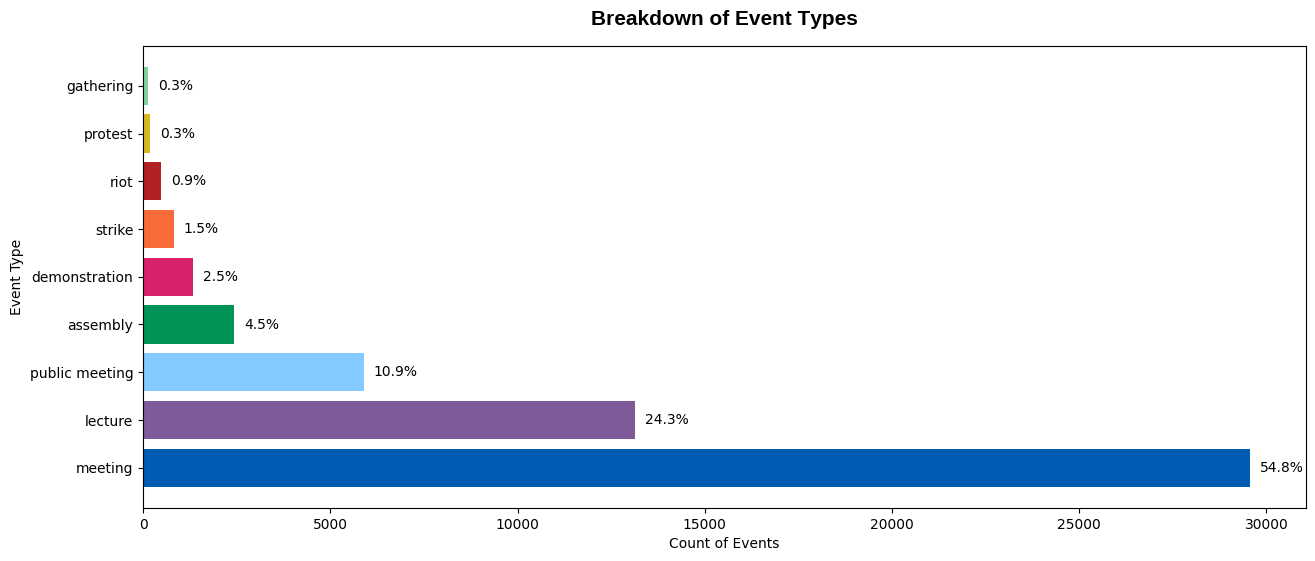

In [25]:
# Calculate percentages
percentages = (event_counts / event_counts.sum()) * 100

# Match colors
colours = [colour_map.get(event, '#333333') for event in event_counts.index]

plt.figure(figsize=(15, 6))

# Horizontal bar chart
bars = plt.barh(
    event_counts.index,      # event types
    event_counts.values,     # counts
    color=colours
)

# Add percentages at the end of each bar
for bar, pct in zip(bars, percentages):
    width = bar.get_width()
    plt.text(width +  event_counts.sum()*0.005, bar.get_y() + bar.get_height()/2,
             f"{pct:.1f}%", va='center')

plt.xlabel('Count of Events')
plt.ylabel('Event Type')
plt.title('Breakdown of Event Types', fontweight='bold', fontname='Liberation Sans', fontsize=15, pad=15)
plt.show()


## Dot distribution

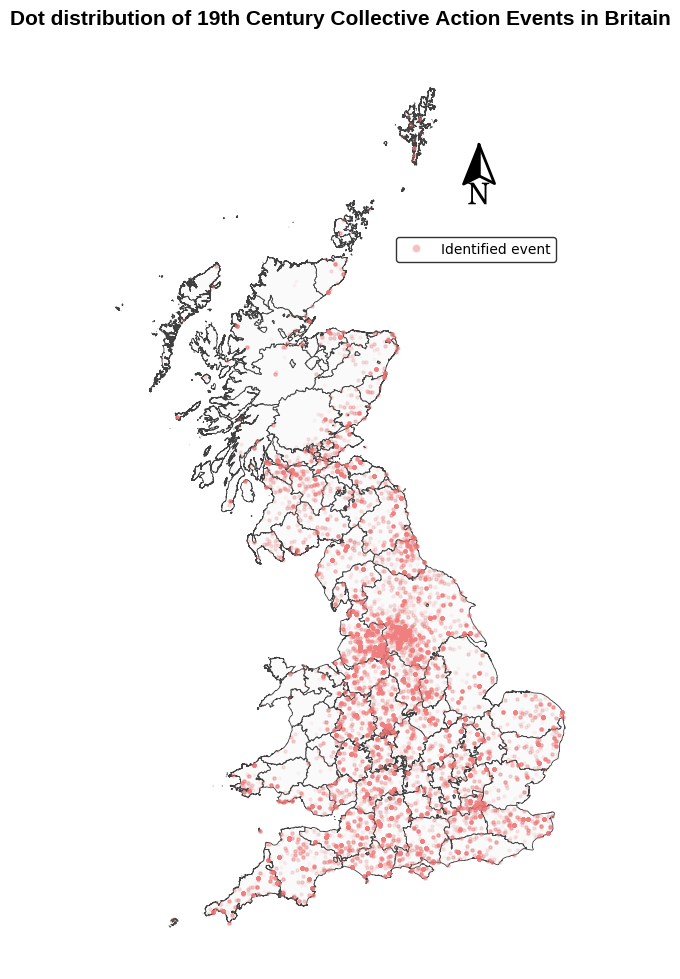

NameError: name 'total_by_county' is not defined

In [26]:
# overlaying and mapping

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 12))


# Plot counties with softer colors
gb_counties.plot(ax=ax, 
              color="#fafafa",      # very light fill
              edgecolor="#404040",  # muted gray edges
              linewidth=0.6)

# Plot events with smaller markers and slightly reduced alpha
events_gdf.plot(ax=ax, 
                color="lightcoral", 
                markersize=5,       # smaller points
                alpha=0.05)          # less transparent (more overlap visible)

ax.set_title("Dot distribution of 19th Century Collective Action Events in Britain", 
             fontweight='bold',
                    fontname='Liberation Sans',
             fontsize=15, pad=15)

# toggle border 
ax.axis('off')

# add 'legend'
event_marker = Line2D([0], [0], marker='o', color='w', label='Identified event',
                      markerfacecolor='lightcoral', markersize=6, alpha=0.5)
ax.legend(handles=[event_marker], loc='upper right', bbox_to_anchor=(0.95, 0.80), frameon=True).get_frame().set_edgecolor('black')

# add north arrow
add_north_arrow(ax, scale=.5, xlim_pos=.78, ylim_pos=.85, color='#000', text_scaler=4, text_yT=-1.25)

plt.show()

# COUNTS - TOP 10
# Sort counties by event_count descending
sorted_counties_count = total_by_county.sort_values(by='event_count', ascending=False)

# View top rows
print(sorted_counties_count.head(n=10))


## County-aggregated event visualisation

### Density by 1841 population

In [ ]:
# ALL EVENTS: TOTAL EVENT COUNT BY COUNTY
counts = joined.groupby('NAME').size().reset_index(name='event_count')

# adding counts to counties gdf by matching county ID -> forming a new df
total_by_county = gb_counties[['NAME', 'geometry', 'pop_1841']].merge(counts,
                              how="left",
                              left_on='NAME',
                              right_on='NAME')

# fill counties with no events with 0
total_by_county['event_count'] = total_by_county['event_count'].fillna(0)

In [ ]:
# combining orkney and shetland since i only have their combined 1841 population data

# Create a mask for the rows to combine
orkney_mask = total_by_county['NAME'].str.contains('orkney', case=False)
shetland_mask = total_by_county['NAME'].str.contains('shetland', case=False)

# Get the sum of the event counts for these rows
orkshet_combined = total_by_county.loc[orkney_mask, 'event_count'].values[0] + \
                 total_by_county.loc[shetland_mask, 'event_count'].values[0]

# Create a new row with the combined data
orkshet_row = {
    'NAME': 'orkneyshetland',
    'geometry': total_by_county.loc[orkney_mask, 'geometry'].values[0].union(
                total_by_county.loc[shetland_mask, 'geometry'].values[0]),
    'pop_1841': total_by_county.loc[orkney_mask, 'pop_1841'].values[0],
    'event_count': orkshet_combined
}

# Remove the original rows and add the combined one
total_by_county = total_by_county[~orkney_mask & ~shetland_mask]
total_by_county = total_by_county._append(orkshet_row, ignore_index=True)

# normalising event counts by population (per 10,000 people)
total_by_county['event_density'] = total_by_county['event_count']/(total_by_county['pop_1841'] / 10000)
total_by_county

,NAME,geometry,pop_1841,event_count,event_density
0,aberdeenshire,"MULTIPOLYGON (((342589.132 839263.386, 342580....",192387,364.0,18.920197
1,anglesey,"MULTIPOLYGON (((224718.558 383238.255, 224719....",50890,1.0,0.196502
2,angus,"MULTIPOLYGON (((370655.614 748115.446, 370653....",170520,216.0,12.667136
3,argyllshire,"MULTIPOLYGON (((211212.557 775556.094, 211198....",97371,112.0,11.502398
4,ayrshire,"MULTIPOLYGON (((219856.152 603170.384, 219860....",164356,225.0,13.689795
...,...,...,...,...,...
80,wigtownshire,"MULTIPOLYGON (((244541.375 534362.165, 244540....",39195,103.0,26.278862
81,wiltshire,"MULTIPOLYGON (((472728.929 164809.005, 472731....",258733,1124.0,43.442468
82,worcestershire,"MULTIPOLYGON (((399890.608 287796.259, 399895....",233836,546.0,23.349698
83,yorkshire,"MULTIPOLYGON (((495019.509 423635.702, 494846....",1591480,7020.0,44.109885


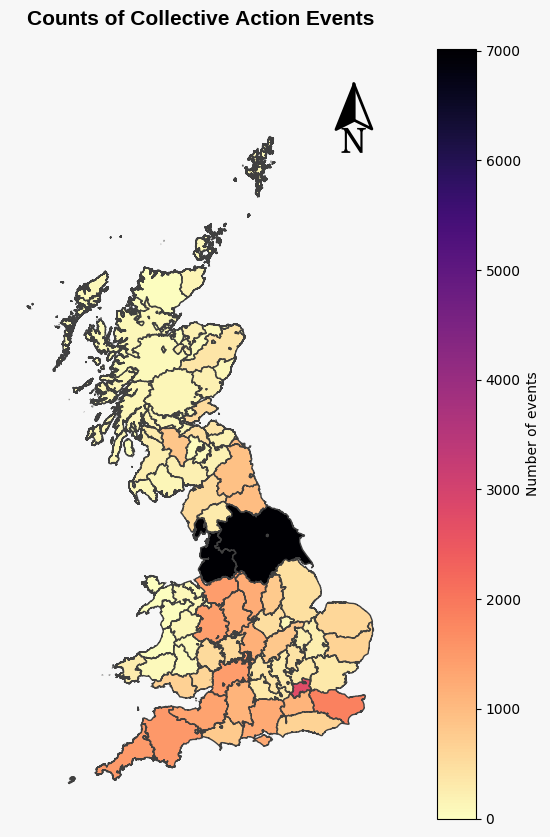

In [ ]:

# --- PLOT 1: COUNTS ---
fig1, ax1 = plt.subplots(figsize=(12, 10), facecolor="#f7f7f7")

total_by_county.plot(
    column='event_count',
    cmap='magma_r',
    legend=True,
    edgecolor='#404040',
    legend_kwds={'label': "Number of events"},
    ax=ax1
)

ax1.set_title(
    "Counts of Collective Action Events",
    fontweight='bold',
    fontname='Liberation Sans',
    fontsize=15
)

ax1.axis('off')
add_north_arrow(ax1, scale=.75, xlim_pos=.9025, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)

plt.show()



             NAME                                           geometry  \
29   east lothian  MULTIPOLYGON (((351198.565 687022.463, 351202....   
68   selkirkshire  MULTIPOLYGON (((345902.902 639888.983, 345901....   
69     shropshire  MULTIPOLYGON (((400385.849 287247.397, 400401....   
53     morayshire  MULTIPOLYGON (((319921.458 871971.908, 319923....   
8    berwickshire  MULTIPOLYGON (((368942.098 638095.74, 368948.8...   
67        rutland  POLYGON ((481468.666 311825.503, 481468.771 31...   
79    westmorland  MULTIPOLYGON (((353662.462 476507.789, 353671....   
36  herefordshire  MULTIPOLYGON (((376630.278 244179.862, 376640....   
51  monmouthshire  MULTIPOLYGON (((345918.028 181065.509, 345916....   
23     derbyshire  MULTIPOLYGON (((440149.171 313724.487, 440102....   

    pop_1841  event_count  event_density  
29     35886        357.0      99.481692  
68      7090         44.0      62.059238  
69    239048       1405.0      58.774807  
53     35012        196.0      55.9

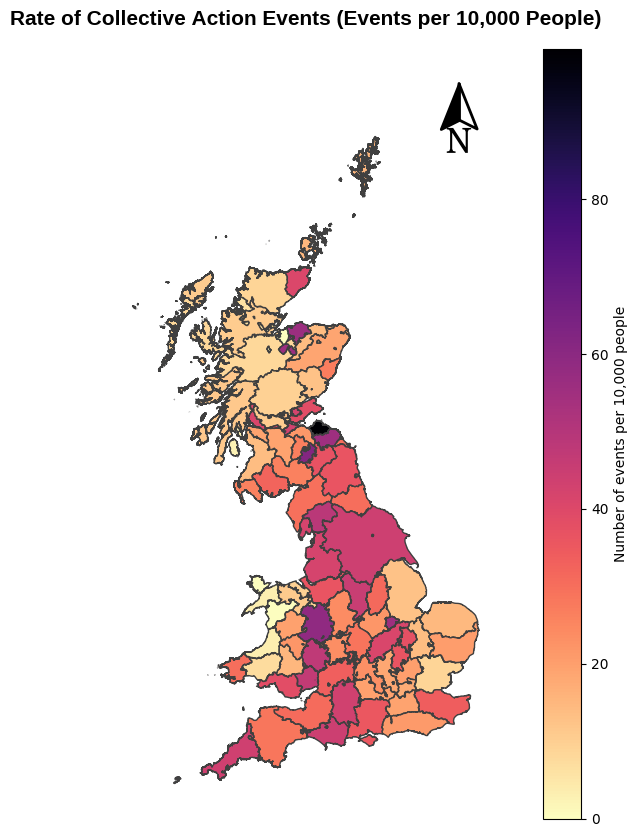

In [ ]:
# Sort counties by event_count descending
sorted_counties_rate= total_by_county.sort_values(by='event_density', ascending=False)

# View top rows
print(sorted_counties_rate.head(n=10))

# --- PLOT 2: DENSITY ---
fig2, ax2 = plt.subplots(figsize=(12, 10))

total_by_county.plot(
    column='event_density',
    cmap='magma_r',
    legend=True,
    edgecolor='#404040',
    legend_kwds={'label': "Number of events per 10,000 people"},
    ax=ax2
)

ax2.set_title(
    "Rate of Collective Action Events (Events per 10,000 People)",
    fontweight='bold',
    fontname='Liberation Sans',
    fontsize=15
)

ax2.axis('off')
add_north_arrow(ax2, scale=.75, xlim_pos=.9025, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)

plt.show()


## Plotting the densities of SPECIFIC EVENT TYPES across counties


In [ ]:
# FOR EACH EVENT: HOW MANY OF EACH EVENT BY COUNTY
events_by_county = joined.groupby("NAME")["event"].value_counts().unstack(fill_value=0)
events_by_county = gb_counties[['NAME','geometry', 'pop_1841']].merge(events_by_county,
                              how="left",
                              left_on='NAME',
                              right_on='NAME')


# combining orkney and shetland again

# Create a mask for the rows to combine
orkney_mask = events_by_county['NAME'].str.contains('orkney', case=False)
shetland_mask = events_by_county['NAME'].str.contains('shetland', case=False)

# Get event columns (all columns except 'NAME', 'geometry', 'pop_1841')
event_columns = [col for col in events_by_county.columns if col not in ['NAME', 'geometry', 'pop_1841']]


# Create combined row
orkshet_combined = {
    'NAME': 'orkneyshetland',
    'geometry': events_by_county.loc[orkney_mask, 'geometry'].values[0].union(
                events_by_county.loc[shetland_mask, 'geometry'].values[0]),
    'pop_1841': events_by_county.loc[orkney_mask, 'pop_1841'].values[0]
}

# Sum events for each event type
for event in event_columns:
    orkshet_combined[event] = (events_by_county.loc[orkney_mask, event].values[0] + 
                          events_by_county.loc[shetland_mask, event].values[0])

# Remove the original rows and add the combined one
events_by_county = events_by_county[~orkney_mask & ~shetland_mask]
events_by_county = events_by_county._append(orkshet_combined, ignore_index=True)

events_by_county


,NAME,geometry,pop_1841,assembly,demonstration,gathering,lecture,meeting,protest,public meeting,riot,strike
0,aberdeenshire,"MULTIPOLYGON (((342589.132 839263.386, 342580....",192387,6.0,3.0,0.0,50.0,266.0,5.0,31.0,0.0,3.0
1,anglesey,"MULTIPOLYGON (((224718.558 383238.255, 224719....",50890,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,angus,"MULTIPOLYGON (((370655.614 748115.446, 370653....",170520,19.0,2.0,0.0,41.0,132.0,0.0,22.0,0.0,0.0
3,argyllshire,"MULTIPOLYGON (((211212.557 775556.094, 211198....",97371,8.0,5.0,0.0,19.0,58.0,5.0,17.0,0.0,0.0
4,ayrshire,"MULTIPOLYGON (((219856.152 603170.384, 219860....",164356,1.0,6.0,0.0,30.0,173.0,0.0,14.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80,wigtownshire,"MULTIPOLYGON (((244541.375 534362.165, 244540....",39195,4.0,0.0,0.0,11.0,86.0,0.0,2.0,0.0,0.0
81,wiltshire,"MULTIPOLYGON (((472728.929 164809.005, 472731....",258733,37.0,18.0,0.0,377.0,552.0,1.0,114.0,10.0,15.0
82,worcestershire,"MULTIPOLYGON (((399890.608 287796.259, 399895....",233836,29.0,5.0,0.0,173.0,248.0,5.0,79.0,3.0,4.0
83,yorkshire,"MULTIPOLYGON (((495019.509 423635.702, 494846....",1591480,313.0,209.0,36.0,1626.0,4058.0,17.0,626.0,69.0,66.0


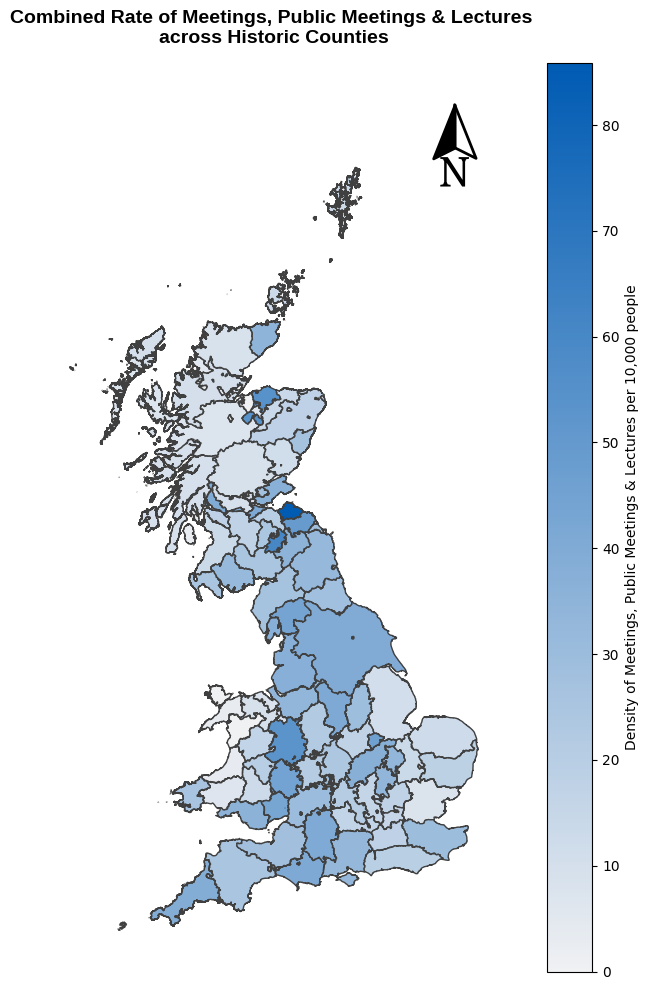

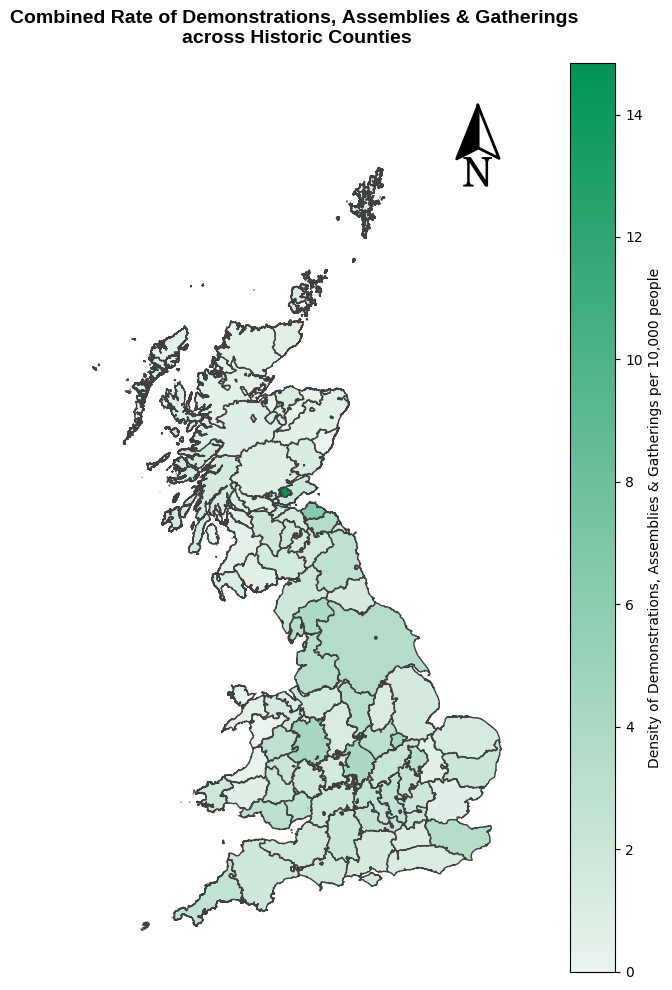

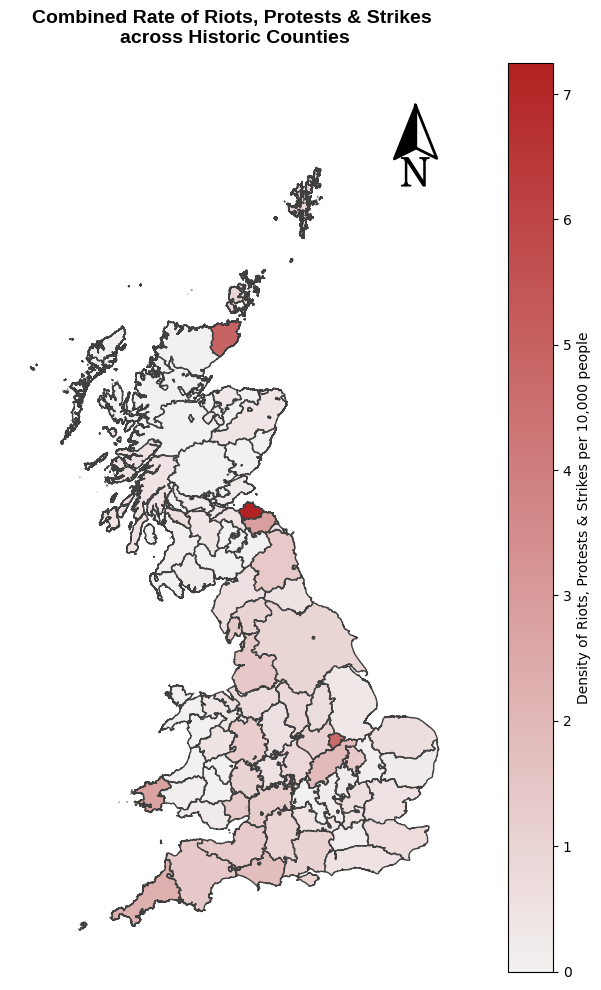

In [ ]:
# Define the three groups of events
event_groups = {
    'Meetings, Public Meetings & Lectures': ['meeting', 'public meeting', 'lecture'],
    'Demonstrations, Assemblies & Gatherings': ['assembly', 'gathering', 'demonstration'],
    'Riots, Protests & Strikes': ['riot', 'protest', 'strike']
}

# Loop over each group and create a separate plot
for title, event_list in event_groups.items():
    # Sum counts for this group
    total_counts = events_by_county[event_list].sum(axis=1)
    
    # Calculate density per 10,000 population
    density = total_counts / (events_by_county['pop_1841'] / 10000)
    
    # Choose a color (using the first event in the list as base)
    color_hex = colour_map[event_list[0]]
    
    # Create a new figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # Adjust width if needed
    
    # Plot choropleth
    events_by_county.plot(
        column=density,
        cmap=sns.light_palette(color_hex, as_cmap=True),
        legend=True,
        edgecolor='#404040',
        legend_kwds={'label': f"Density of {title} per 10,000 people"},
        ax=ax
    )
    
    # Title and axis adjustments
    ax.set_title(
        f"Combined Rate of {title} \nacross Historic Counties",
        fontweight='bold',
        fontname='Liberation Sans',
        fontsize=14,
        pad=15
    )
    ax.axis('off')
    
    # Add north arrow
    add_north_arrow(ax, scale=.75, xlim_pos=.9025, ylim_pos=.965, 
                    color='#000', text_scaler=4, text_yT=-1.25)
    
    plt.tight_layout()
    plt.show()



In [ ]:
# top 10 performing counties for each composite category
# Create an empty dictionary to store top 10 tables
top10_tables = {}

for title, event_list in event_groups.items():
    # Sum counts for this group
    total_counts = events_by_county[event_list].sum(axis=1)
    
    # Calculate density per 10,000 population
    poprate = total_counts / (events_by_county['pop_1841'] / 10000)
    
    # Build a temporary DataFrame
    temp_df = events_by_county[['NAME']].copy()
    temp_df['Total Count'] = total_counts
    temp_df['Rate per 10,000 people'] = poprate
    
    # Sort descending by density and take top 10
    top10 = temp_df.sort_values('Rate per 10,000 people', ascending=False).head(10)
    
    # Store in dictionary
    top10_tables[title] = top10

top10_tables

{'Meetings, Public Meetings & Lectures':              NAME  Total Count  Rate per 10,000 people
 29   east lothian        308.0               85.827342
 68   selkirkshire         43.0               60.648801
 53     morayshire        191.0               54.552725
 69     shropshire       1270.0               53.127405
 8    berwickshire        169.0               49.073698
 67        rutland         99.0               46.474509
 36  herefordshire        511.0               44.872583
 79    westmorland        247.0               43.752436
 51  monmouthshire        576.0               42.871497
 25         dorset        721.0               41.189879,
 'Demonstrations, Assemblies & Gatherings':              NAME  Total Count  Rate per 10,000 people
 42  kinross-shire         13.0               14.835102
 29   east lothian         23.0                6.409185
 69     shropshire        105.0                4.392423
 67        rutland          9.0                4.224955
 77   warwickshire  

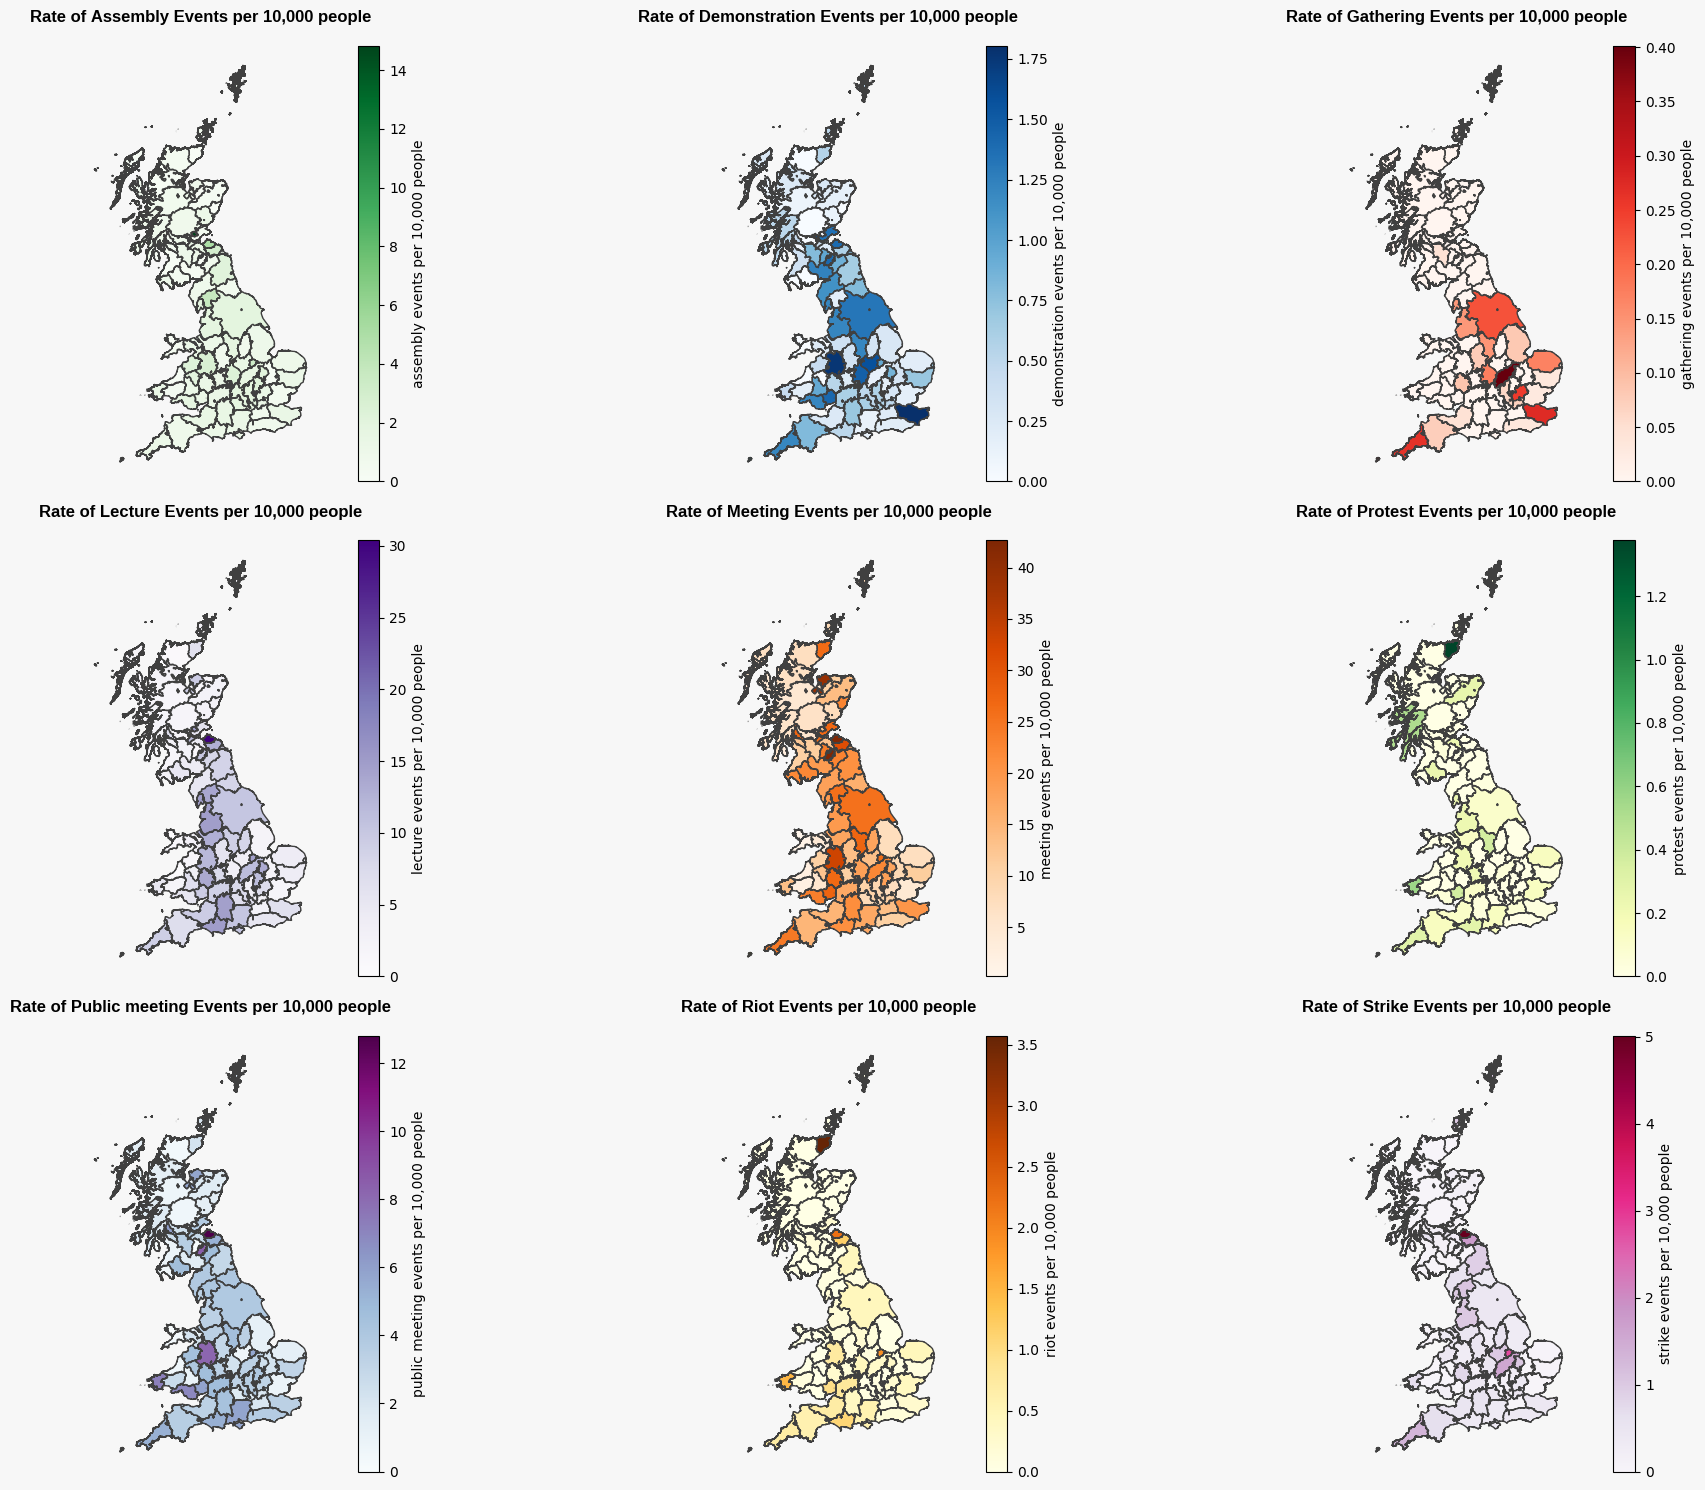

In [ ]:
# List of event columns and colormaps for variety
event_columns = [
    'assembly', 'demonstration', 'gathering', 'lecture',
    'meeting', 'protest', 'public meeting', 'riot', 'strike'
]

# Choose 9 visually distinct colormaps
colormaps = [
    'Greens', 'Blues', 'Reds', 'Purples', 
    'Oranges', 'YlGn', 'BuPu', 'YlOrBr', 'PuRd'
]

# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(21, 15), facecolor="#f7f7f7")
axes = axes.flatten()

for idx, (event, cmap) in enumerate(zip(event_columns, colormaps)):
    ax = axes[idx]

    # calculating event density, dividing counts by county area
    density = events_by_county[event] / (events_by_county['pop_1841']/10000)
    
    events_by_county.plot(
        column=density,
        cmap=cmap,
        legend=True,
        edgecolor='#404040',
        legend_kwds={'label': f"{event} events per 10,000 people"},
        ax=ax
    )
    
    ax.set_title(
        f"Rate of {event.capitalize()} Events per 10,000 people",
        fontweight='bold',
        fontname='Liberation Sans',
        fontsize=12
    )
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5-yearly LQ analysis
1. 1838-1842
2. 1843-1847
3. 1848-1852

In [ ]:
joined_periods = joined.copy()

periods = [
    ('1838-01-01', '1842-12-31'),
    ('1843-01-01', '1847-12-31'),
    ('1848-01-01', '1852-12-31')
]

period_labels = [f'{pd.to_datetime(p[0]).year}-{pd.to_datetime(p[1]).year}' for p in periods]

# Add a new 'period' column to our cleaned DataFrame
joined_periods['period'] = None
for i, period in enumerate(periods):
    start_date, end_date = pd.to_datetime(period[0]), pd.to_datetime(period[1])
    mask = (joined_periods['date'] >= start_date) & (joined_periods['date'] <= end_date)
    joined_periods.loc[mask, 'period'] = period_labels[i]

# Drop events outside of periods of interest
joined_periods.dropna(subset=['period'], inplace=True)

# getting period counts by county, merging with gb_counties so that all counties are kept even if they have no events
events_periods = (gb_counties[['NAME']].merge(joined_periods.pivot_table(index='NAME',columns='period',aggfunc='size',fill_value=0).reset_index(),on='NAME',how='left' ).fillna(0))
events_periods


,NAME,1838-1842,1843-1847,1848-1852
0,aberdeenshire,192.0,124.0,47.0
1,anglesey,1.0,0.0,0.0
2,angus,123.0,65.0,28.0
3,argyllshire,44.0,54.0,14.0
4,ayrshire,112.0,64.0,49.0
...,...,...,...,...
81,westmorland,139.0,85.0,50.0
82,wigtownshire,30.0,59.0,12.0
83,wiltshire,582.0,363.0,143.0
84,worcestershire,257.0,185.0,91.0


In [ ]:
# adding period counts to gb_counties
period_data = gb_counties.merge(events_periods, on='NAME', how='left')


# combining orkney and shetland again
orkney_mask = period_data['NAME'].str.contains('orkney', case=False)
shetland_mask = period_data['NAME'].str.contains('shetland', case=False)

# Create combined row
orkshet_combined = {
    'NAME': 'orkneyshetland',
    'geometry': period_data.loc[orkney_mask, 'geometry'].values[0].union(
                period_data.loc[shetland_mask, 'geometry'].values[0]),
    'pop_1841': period_data.loc[orkney_mask, 'pop_1841'].values[0]
}

# Sum events for each period
period_columns = ['1838-1842', '1843-1847', '1848-1852']

for period in period_columns:
    orkshet_combined[period] = (period_data.loc[orkney_mask, period].values[0] + 
                          period_data.loc[shetland_mask, period].values[0])

# Remove the original rows and add the combined one
period_data = period_data[~orkney_mask & ~shetland_mask]
period_data = period_data._append(orkshet_combined, ignore_index=True)

period_data


,NAME,HCS_NUMBER,geometry,pop_1841,1838-1842,1843-1847,1848-1852
0,aberdeenshire,1.0,"MULTIPOLYGON (((342589.132 839263.386, 342580....",192387,192.0,124.0,47.0
1,anglesey,2.0,"MULTIPOLYGON (((224718.558 383238.255, 224719....",50890,1.0,0.0,0.0
2,angus,3.0,"MULTIPOLYGON (((370655.614 748115.446, 370653....",170520,123.0,65.0,28.0
3,argyllshire,5.0,"MULTIPOLYGON (((211212.557 775556.094, 211198....",97371,44.0,54.0,14.0
4,ayrshire,7.0,"MULTIPOLYGON (((219856.152 603170.384, 219860....",164356,112.0,64.0,49.0
...,...,...,...,...,...,...,...
80,wigtownshire,89.0,"MULTIPOLYGON (((244541.375 534362.165, 244540....",39195,30.0,59.0,12.0
81,wiltshire,90.0,"MULTIPOLYGON (((472728.929 164809.005, 472731....",258733,582.0,363.0,143.0
82,worcestershire,91.0,"MULTIPOLYGON (((399890.608 287796.259, 399895....",233836,257.0,185.0,91.0
83,yorkshire,92.0,"MULTIPOLYGON (((495019.509 423635.702, 494846....",1591480,3909.0,2147.0,846.0


In [ ]:
# normalise by population (per 10,000 people)
rate_cols = []
for period_label in period_labels:
    rate_col_name = f'rate_all_{period_label}'
    # Fill NaNs with 0 for counties that had no events
    period_data[period_label] = period_data[period_label].fillna(0)
    # Calculate the normalized density
    period_data[rate_col_name] = (period_data[period_label] / (period_data['pop_1841'] / 10000))
    rate_cols.append(rate_col_name)

period_data

,NAME,HCS_NUMBER,geometry,pop_1841,1838-1842,1843-1847,1848-1852,rate_all_1838-1842,rate_all_1843-1847,rate_all_1848-1852
0,aberdeenshire,1.0,"MULTIPOLYGON (((342589.132 839263.386, 342580....",192387,192.0,124.0,47.0,9.979884,6.445342,2.442993
1,anglesey,2.0,"MULTIPOLYGON (((224718.558 383238.255, 224719....",50890,1.0,0.0,0.0,0.196502,0.000000,0.000000
2,angus,3.0,"MULTIPOLYGON (((370655.614 748115.446, 370653....",170520,123.0,65.0,28.0,7.213230,3.811870,1.642036
3,argyllshire,5.0,"MULTIPOLYGON (((211212.557 775556.094, 211198....",97371,44.0,54.0,14.0,4.518799,5.545799,1.437800
4,ayrshire,7.0,"MULTIPOLYGON (((219856.152 603170.384, 219860....",164356,112.0,64.0,49.0,6.814476,3.893986,2.981333
...,...,...,...,...,...,...,...,...,...,...
80,wigtownshire,89.0,"MULTIPOLYGON (((244541.375 534362.165, 244540....",39195,30.0,59.0,12.0,7.654038,15.052940,3.061615
81,wiltshire,90.0,"MULTIPOLYGON (((472728.929 164809.005, 472731....",258733,582.0,363.0,143.0,22.494232,14.029907,5.526933
82,worcestershire,91.0,"MULTIPOLYGON (((399890.608 287796.259, 399895....",233836,257.0,185.0,91.0,10.990609,7.911528,3.891616
83,yorkshire,92.0,"MULTIPOLYGON (((495019.509 423635.702, 494846....",1591480,3909.0,2147.0,846.0,24.562043,13.490587,5.315807


### Getting components for LQ analysis

In [ ]:
# 1. grouping by county, events, period
cep =(joined_periods
    .groupby(['NAME', 'event', 'period'])
    .size()
    .reset_index(name='count'))

# joining orkney and shetland again
orkney_mask = cep['NAME'].str.lower() == 'orkney'
shetland_mask = cep['NAME'].str.lower() == 'shetland'

# Group and sum the counts for the combined region
combined_cep = (
    cep[orkney_mask | shetland_mask]
    .groupby(['event', 'period'], as_index=False)
    .agg({
        'count': 'sum',
        'NAME': lambda x: 'orkneyshetland'  # Set the combined name
    })
)

# Remove original orkney and shetland rows, then add the combined ones
cep_combined = cep[~(orkney_mask | shetland_mask)].copy()
cep_combined = cep_combined._append(combined_cep, ignore_index=True)   
cep_combined

,NAME,event,period,count
0,aberdeenshire,assembly,1838-1842,2
1,aberdeenshire,assembly,1843-1847,4
2,aberdeenshire,demonstration,1838-1842,2
3,aberdeenshire,demonstration,1843-1847,1
4,aberdeenshire,lecture,1838-1842,39
...,...,...,...,...
1174,orkneyshetland,meeting,1848-1852,10
1175,orkneyshetland,public meeting,1838-1842,8
1176,orkneyshetland,public meeting,1843-1847,3
1177,orkneyshetland,public meeting,1848-1852,1


In [ ]:
# 2. total events per event per period
ep_totals = (
    joined_periods
    .groupby(['event', 'period'])
    .size()
    .reset_index(name='gb_total')
)
ep_totals

,event,period,gb_total
0,assembly,1838-1842,1278
1,assembly,1843-1847,697
2,assembly,1848-1852,251
3,demonstration,1838-1842,878
4,demonstration,1843-1847,226
5,demonstration,1848-1852,177
6,gathering,1838-1842,67
7,gathering,1843-1847,34
8,gathering,1848-1852,36
9,lecture,1838-1842,8431


In [ ]:
# 3. total events per county per period
cp_totals = (
    joined_periods
    .groupby(['NAME', 'period'])
    .size()
    .reset_index(name='county_total')
)

# combining orkney and shetland
# Create a mask for orkney and shetland
orkney_mask = cp_totals['NAME'].str.lower() == 'orkney'
shetland_mask = cp_totals['NAME'].str.lower() == 'shetland'

# Get the combined data
combined = []
for period in cp_totals['period'].unique():
    orkney_data = cp_totals[orkney_mask & (cp_totals['period'] == period)]
    shetland_data = cp_totals[shetland_mask & (cp_totals['period'] == period)]
    
    combined_count = 0
    if not orkney_data.empty:
        combined_count += orkney_data['county_total'].values[0]
    if not shetland_data.empty:
        combined_count += shetland_data['county_total'].values[0]
    
    if not (orkney_data.empty and shetland_data.empty):
        combined.append({
            'NAME': 'orkneyshetland',
            'period': period,
            'county_total': combined_count
        })

cp_totals_combined = cp_totals[~orkney_mask & ~shetland_mask].copy()
cp_totals_combined = cp_totals_combined._append(combined, ignore_index=True)
cp_totals_combined

,NAME,period,county_total
0,aberdeenshire,1838-1842,192
1,aberdeenshire,1843-1847,124
2,aberdeenshire,1848-1852,47
3,anglesey,1838-1842,1
4,angus,1838-1842,123
...,...,...,...
239,yorkshire,1843-1847,2147
240,yorkshire,1848-1852,846
241,orkneyshetland,1838-1842,24
242,orkneyshetland,1843-1847,57


In [ ]:
# 4. total events per period 
p_totals = (joined_periods
    .groupby('period')
    .size()
    .reset_index(name='grand_total'))
p_totals

,period,grand_total
0,1838-1842,28786
1,1843-1847,16614
2,1848-1852,7531


In [ ]:
# calculating LQ based on event composite categories
event_groups = {
    'organised': ['meeting', 'public meeting', 'lecture'],
    'contentious': ['riot', 'protest', 'strike'],
    'rally': ['gathering', 'assembly', 'demonstration']
}

# Create event -> group mapping
event_to_group = {}
for group, events in event_groups.items():
    for event in events:
        event_to_group[event] = group
        
# map events in 'cep' to groups
cep_combined['group'] = cep_combined['event'].map(event_to_group)

# 4. Sum counts by county, period, and group
cep_grouped_sum = cep_combined.groupby(['NAME', 'period', 'group'], as_index=False)['count'].sum()

# 5. Calculate GB totals by group and period
gb_group_totals = cep_grouped_sum.groupby(['group', 'period'], as_index=False)['count'].sum()
gb_group_totals.rename(columns={'count': 'gb_group_total'}, inplace=True)

# 7. Merge all totals with cep_grouped_sum to prepare LQ calculation
lq_df_grouped = cep_grouped_sum.merge(
    cp_totals_combined, on=['NAME', 'period'], how='left'
).merge(
    gb_group_totals, on=['group', 'period'], how='left'
).merge(
    p_totals, on='period', how='left'
)

# 8. Calculate Location Quotient
lq_df_grouped['LQ'] = (lq_df_grouped['count'] / lq_df_grouped['county_total']) / (lq_df_grouped['gb_group_total'] / lq_df_grouped['grand_total'])

# 9. Fill NaN LQ values with 0 (for counties with no events in that group)
lq_df_grouped['LQ'] = lq_df_grouped['LQ'].fillna(0)

# 10. Create the full index of all counties, periods, and groups
all_counties = cep_combined['NAME'].unique()
all_periods = cep_combined['period'].unique()
all_groups = list(event_groups.keys())

full_index = pd.MultiIndex.from_product(
    [all_counties, all_periods, all_groups],
    names=['NAME', 'period', 'group']
)

# 11. Reindex your lq_df_grouped to have all combos, fill missing LQ with 0
lq_df_grouped = lq_df_grouped.set_index(['NAME', 'period', 'group']).reindex(full_index, fill_value=0).reset_index()


In [ ]:
# pivoting lq_df_grouped: groups become cols, index by county and period
lq_pivot = lq_df_grouped.pivot_table(index=['NAME', 'period'], columns='group', values='LQ', fill_value=0).reset_index()
lq_pivot

group,NAME,period,contentious,organised,rally
0,aberdeenshire,1838-1842,0.000000,1.093467,0.273091
1,aberdeenshire,1843-1847,1.730419,0.996824,0.700752
2,aberdeenshire,1848-1852,0.000000,1.097334,0.000000
3,anglesey,1838-1842,0.000000,1.116732,0.000000
4,anglesey,1843-1847,0.000000,0.000000,0.000000
...,...,...,...,...,...
244,worcestershire,1843-1847,0.165693,1.049937,0.751510
245,worcestershire,1848-1852,0.000000,1.097334,0.000000
246,yorkshire,1838-1842,0.621340,1.001602,1.170331
247,yorkshire,1843-1847,0.856632,1.014699,0.914666


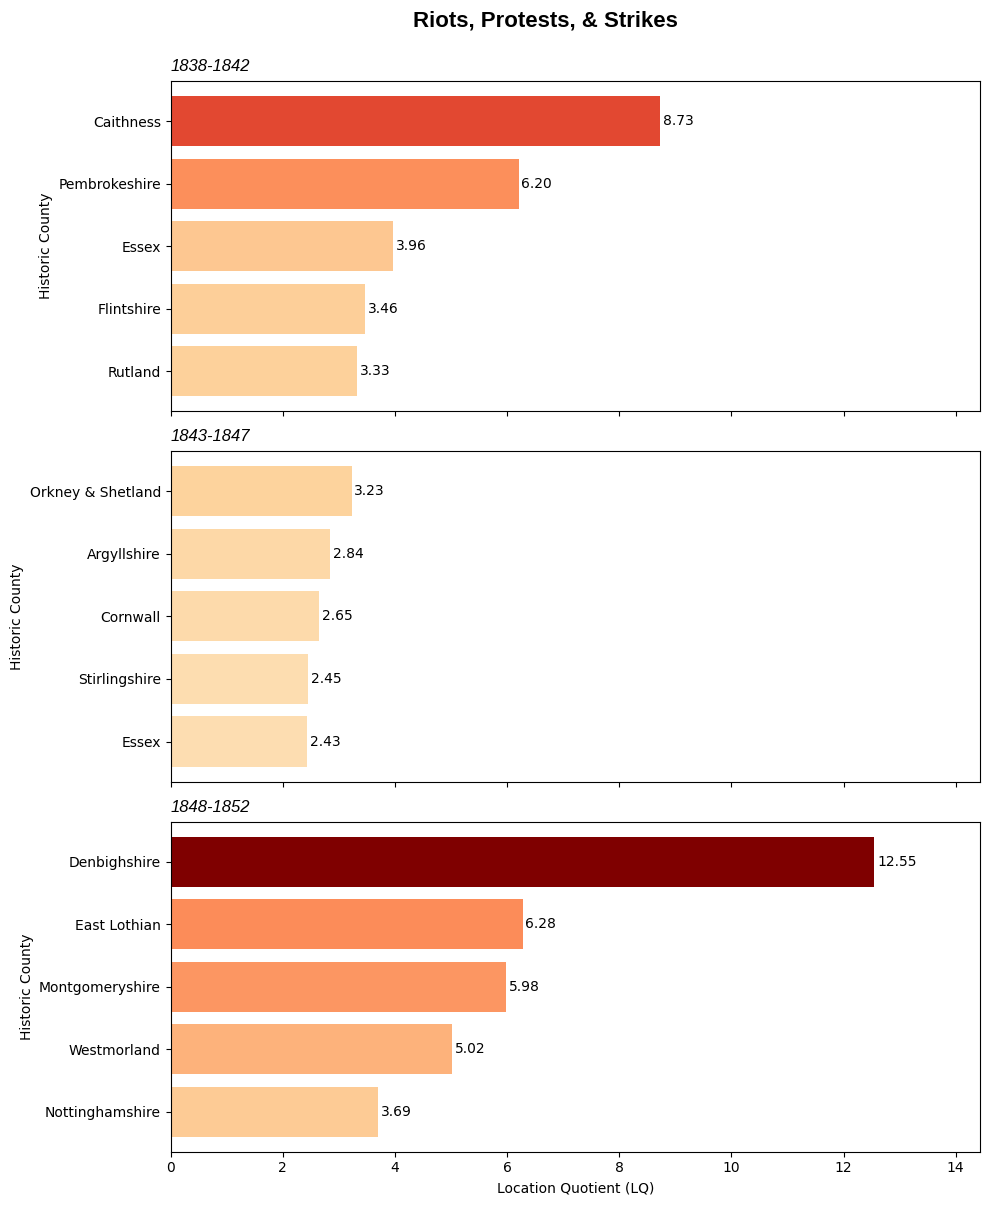

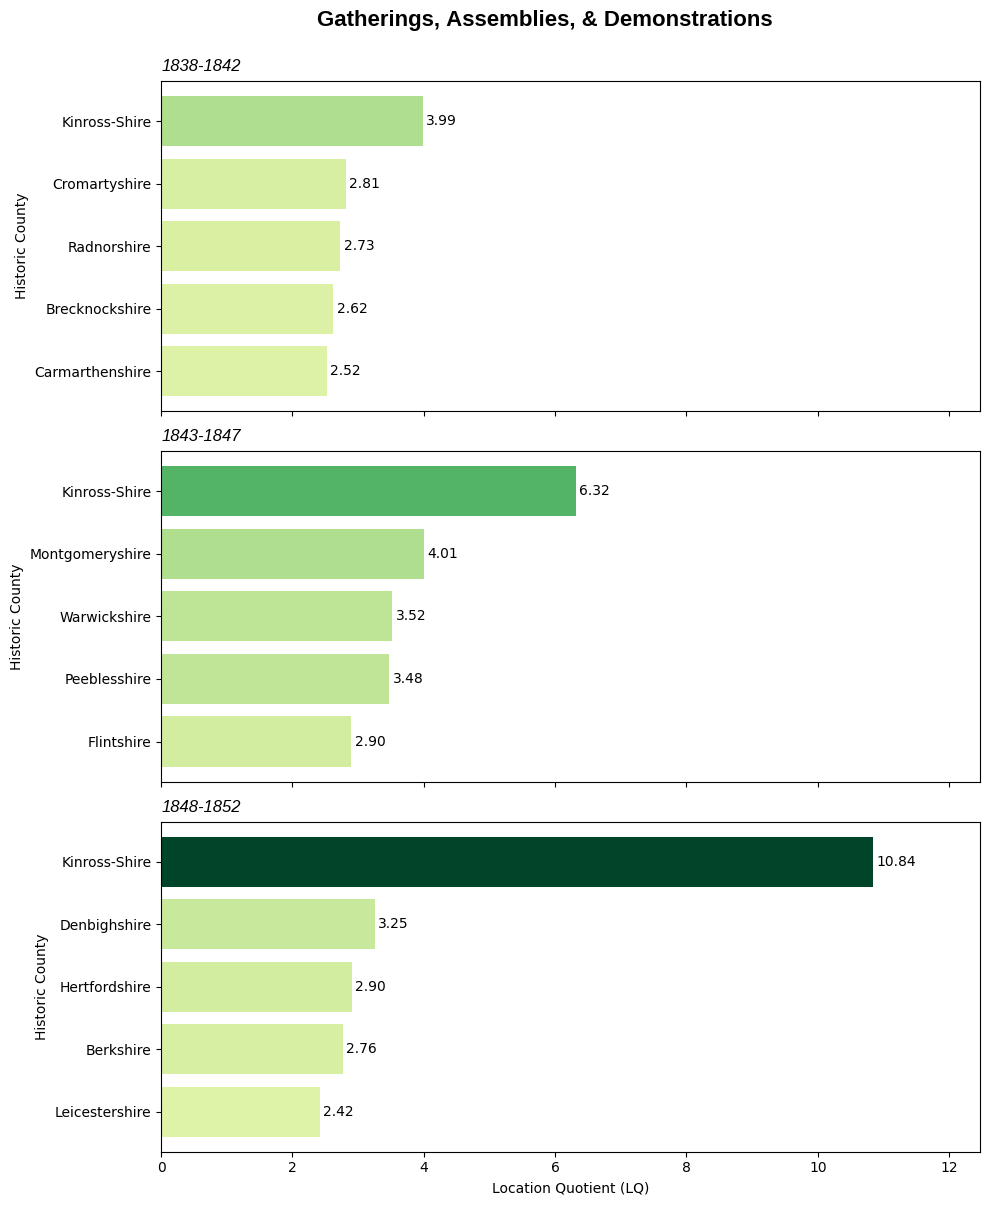

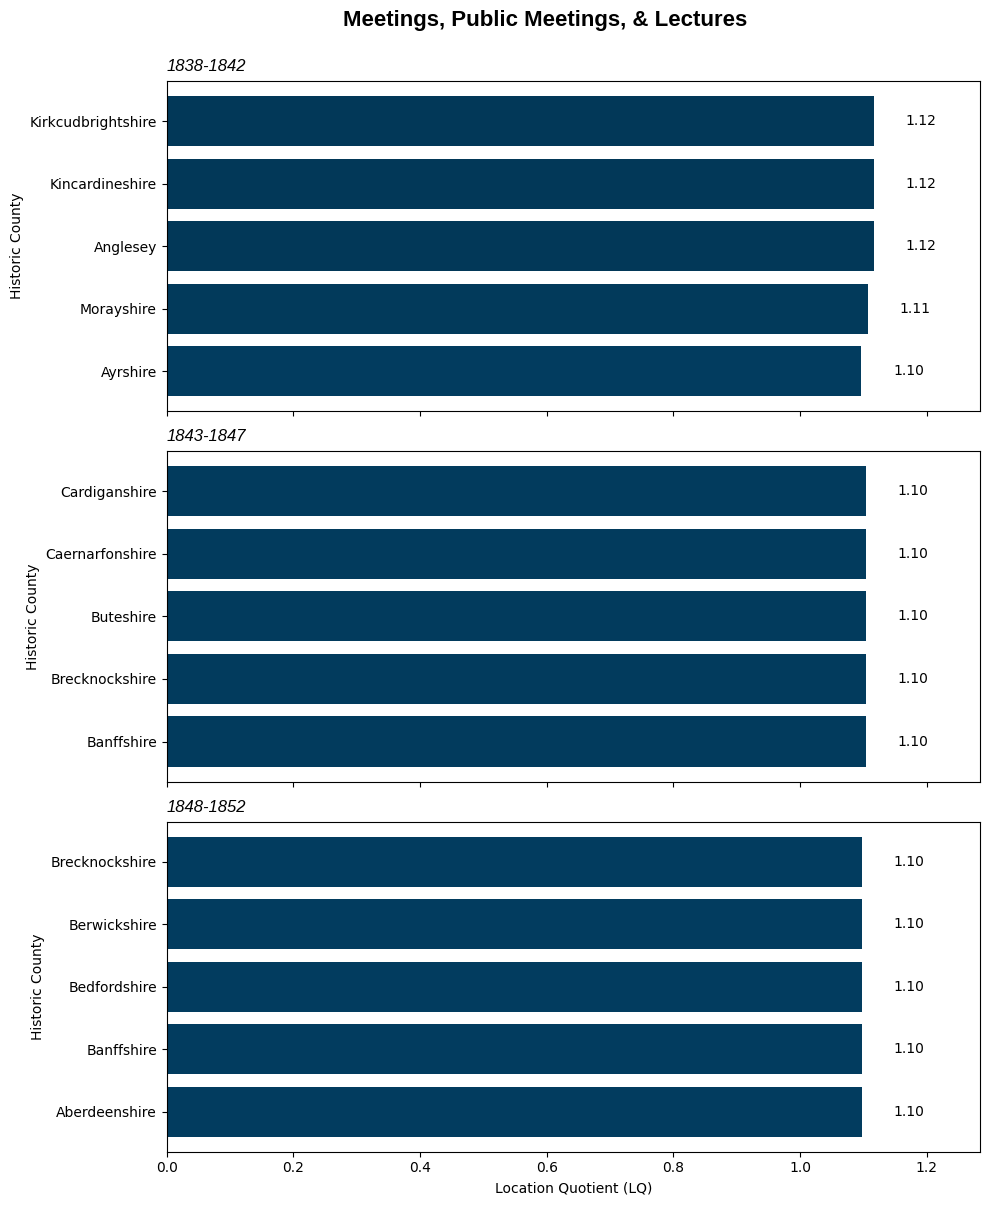

In [ ]:
# Filter for groups
contentious_df = lq_pivot[['NAME', 'period', 'contentious']]
org_df = lq_pivot[['NAME', 'period', 'organised']]
rally_df = lq_pivot[['NAME', 'period', 'rally']]

# Prepare the three dataframes in a dict for looping
group_dfs = {
    'Riots, Protests, & Strikes': {
        'df': contentious_df, 
        'cmap': 'OrRd'},
    'Gatherings, Assemblies, & Demonstrations': {
        'df': rally_df, 
        'cmap': 'YlGn'},
    'Meetings, Public Meetings, & Lectures': {
        'df': org_df, 
        'cmap': 'PuBu'},

}
for group_name, group_info in group_dfs.items():
    df = group_info['df'].copy()
    col = df.columns[2]
    cmap_name = group_info['cmap']

    # Create a figure for each category
    fig, axes = plt.subplots(len(all_periods), 1, figsize=(10, 12), sharex=True)
    
    # Set the event type as the main title, top-centre
    fig.suptitle(group_name, fontsize=16, fontweight='bold', fontname='Liberation Sans', x=0.55, y=1)

    norm = mcolors.Normalize(vmin=df[col].min(), vmax=df[col].max())
    cmap = plt.get_cmap(cmap_name)

    for row_idx, period in enumerate(all_periods):
        ax = axes[row_idx]

        # Top 5 counties for this period
        period_df = df[df['period'] == period].nlargest(5, col).sort_values(col)
        # Replace orkneyshetland with "Orkney & Shetland"
        period_df['NAME'] = period_df['NAME'].replace({'orkneyshetland': 'Orkney & Shetland'})

        colors = [cmap(norm(val)) for val in period_df[col]]

        bars = ax.barh(period_df['NAME'].str.title(), period_df[col], color=colors)
        
        # Add numeric value next to each bar
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.05, bar.get_y() + bar.get_height()/2,
                    f'{width:.2f}', va='center', ha='left', fontsize=10)

        # Expand x-axis to give space for the labels
        ax.set_xlim(0, df[col].max() * 1.15)  # add 15% extra space

        # Add period as a small left-aligned subtitle above each bar chart
        ax.text(0, 1.03, f'{period}', transform=ax.transAxes,
                ha='left', fontsize=12, fontstyle='italic', fontname='Liberation Sans')

        if row_idx == len(all_periods)-1:
            ax.set_xlabel('Location Quotient (LQ)')
        ax.set_ylabel('Historic County')

    plt.tight_layout()
    plt.show()